## Bechdel Data Analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which names the following three criteria: \
 1. it has to have at least two women in it, who \
 2. who talk to each other, about \
 3. something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import json
import math
from statsmodels.stats import diagnostic
from scipy import stats
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.impute import SimpleImputer


### Getting the Bechdel test database and the Movie database

The code below is used to get the Bechdel test results from the API and store them in a DataFrame

In [3]:

url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

Request was succesful
      rating title   imdbid    id  year
2830       3   JFK  0102138  7200  1991


In [4]:
#We now want to get a quick glimpse of the dataset

print(f'The Bechdel database has {df_bechdel.shape[0]} films')
df_bechdel.sample(10)

The Bechdel database has 10447 films


,rating,title,imdbid,id,year
10087,3,Save the Cinema,12048234,10426,2022
990,3,Some Like It Hot,0053291,2023,1959
7787,3,"Pirate Fairy, The",2483260,5453,2014
5932,3,Bring It On: Fight to the Finish,1349482,758,2009
8775,3,Quand on a 17 ans,4331970,8603,2016
939,3,"Mysterians, The",0050251,6624,1957
3749,2,American Pie,0163651,2311,1999
2455,3,Raising Arizona,0093822,3635,1987
3557,3,Deep Impact,0120647,95,1998
3489,3,Selena,0120094,3195,1997


We are now going to extract the CMU Movie Database, to get additional information from those films 

In [5]:
data_folder = './MovieSummaries/'

column_names= ['wikipedia_movie_id', 'freebase_id','title','release_date','revenue','runtime','language','countries','genre']

df_movies=pd.read_csv(data_folder + 'movie.metadata.tsv', sep = '\t', names=column_names)

print(f'The CMU Movies database has {df_movies.shape[0]} films')
df_movies.sample(5)


The CMU Movies database has 81741 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre
80799,30020429,/m/0dj5rqm,Into the Wind,2010-09-28,NaN,51.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01z02hx"": ""Sports"", ""/m/0jtdp"": ""Document..."
24328,31093288,/m/0gh9077,Prince Vaali,2011-10-26,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
73883,24632259,/m/080g2m_,Memorandum,1965,NaN,58.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...","{""/m/0d060g"": ""Canada""}","{""/m/0jtdp"": ""Documentary"", ""/m/082gq"": ""War f..."
42671,9899953,/m/02pwc76,Nit-witty Kitty,1951-10-06,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hqxf"": ""Famil..."
52521,2235711,/m/06y4vs,Elvis Presley's '68 Comeback Special,1968-12-03,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04rlf"": ""Music"", ""/m/04t36"": ""Musical""}"


We start by cleaning the database for films with invalid runtime 

In [6]:
wrong_values = df_movies[
    (df_movies['runtime'] <= 0) |
    (df_movies['runtime'] > 14400)
]

df_movies.loc[wrong_values.index, 'runtime'] = pd.NA

print(f"There are {wrong_values.shape[0]} movies with invalid runtimes. These have been replaced with NaNs.")

There are 2 movies with invalid runtimes. These have been replaced with NaNs.


We now merge the two dataframes together

In [7]:
#We are going to create a database where we merge the bechdel and the movie database, so that we can have all of the information of those films 
# in one single dataframe. We will merge it on year and title, to avoid having one title of he Bechdel database to many movies in the movie database.

# Convert release_date to datetime format (if it's not already in datetime)
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extract the year from the release_date column
df_movies['year'] = df_movies['release_date'].dt.year

# Merge the datasets by 'title' and 'year'
df_movies_bechdel = pd.merge(df_movies, df_bechdel, how='inner', on=['title', 'year'])


df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','wikipedia_movie_id'])


print(f'The combined Bechdel and CMU Movies database has {df_movies_bechdel.shape[0]} films')

df_movies_bechdel.head()

The combined Bechdel and CMU Movies database has 3124 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,bechdel_score,imdbid
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,3,0228333
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,3,0097499
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,3,0058331
3,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1989.0,3,0097790
4,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",1968.0,3,0063642


To avoid bias in the results due to years with very few films, we filtered out all years that had fewer than 10 films. This ensures that each year included in the analysis has a meaningful number of films, providing more reliable results.

In [8]:
year_counts = df_movies_bechdel['year'].value_counts()

# Filter years with at least 10 films
valid_years = year_counts[year_counts >= 10].index

# Keep only rows where the 'year' is in the valid_years list
year_filtered_df = df_movies_bechdel[df_movies_bechdel['year'].isin(valid_years)]

year_filtered_df.head()

df_movies_bechdel = year_filtered_df

### Bechdel test results along the years

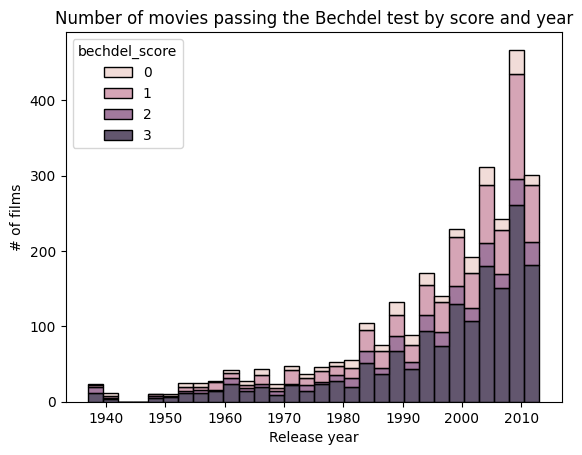

In [9]:
#we here want to plot the number of movies passing the Bechdel test by year and by score

sns.histplot(data=df_movies_bechdel, x='year', hue='bechdel_score',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('# of films');




We observe a clear increase in the number of films passing the Bechdel Test over the years. 

Let's now plot the evolution of the number of films for different scores plotted separately

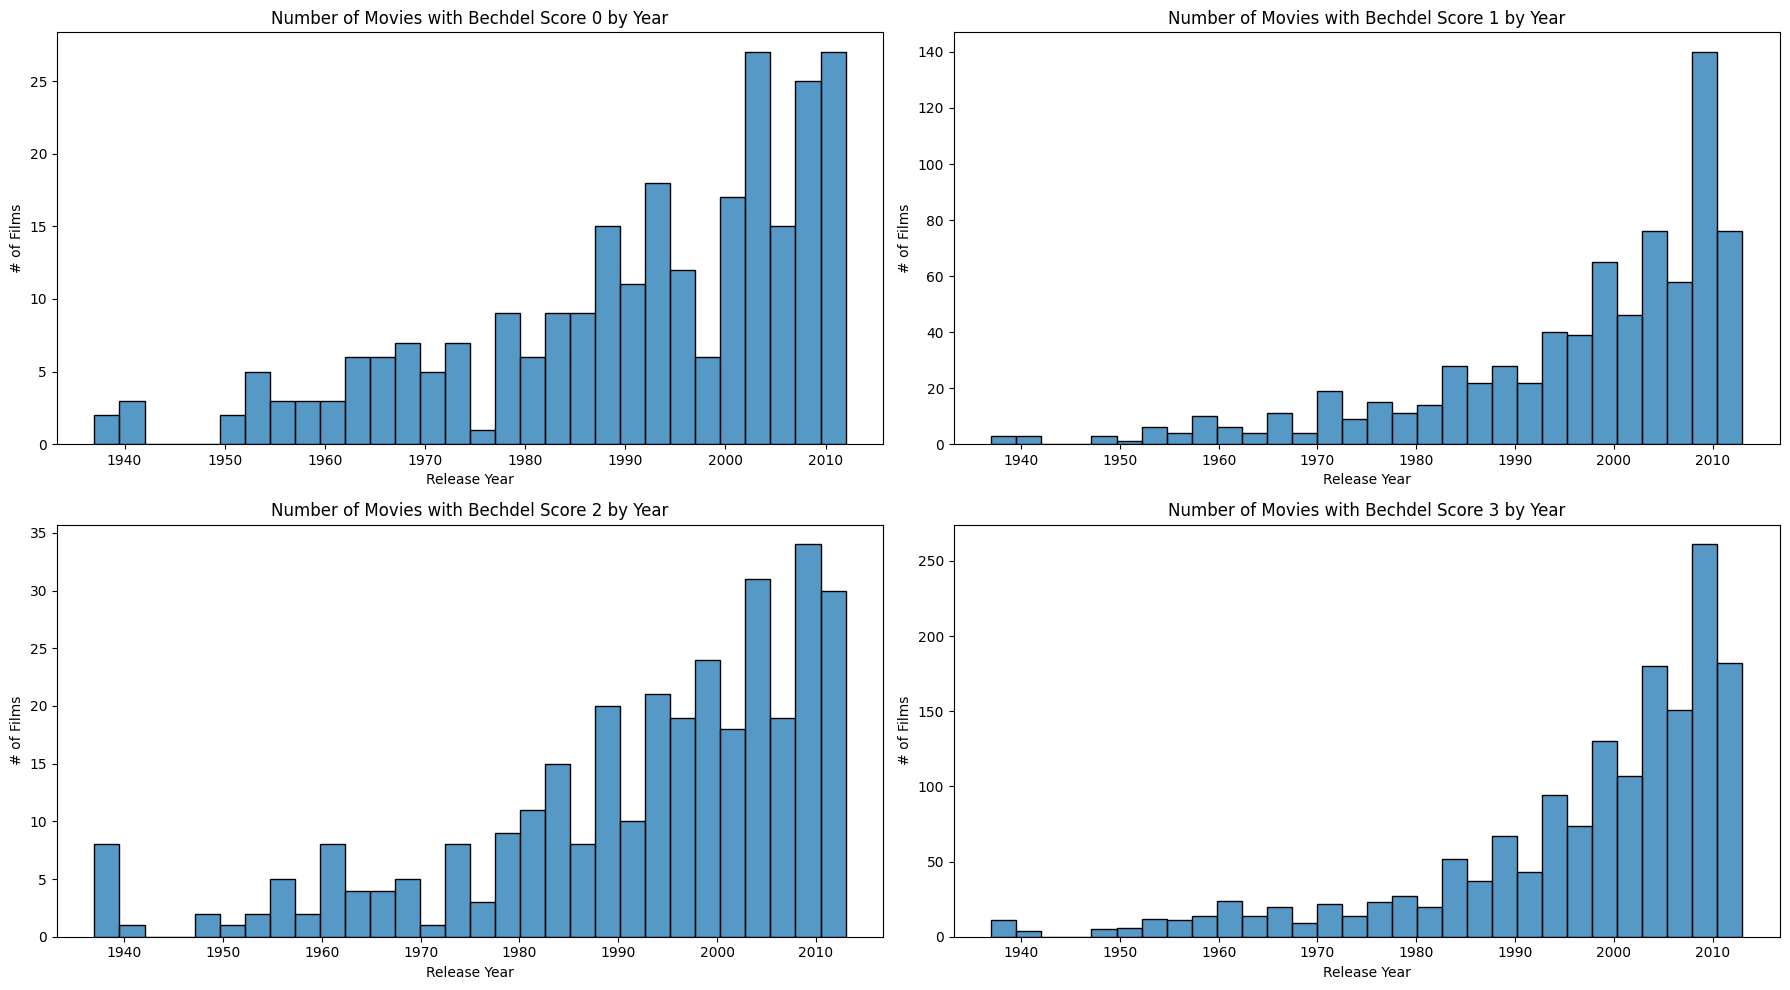

In [10]:
# Set up the figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Define the scores and axes
scores = [0, 1, 2, 3]
titles = [
    "Number of Movies with Bechdel Score 0 by Year",
    "Number of Movies with Bechdel Score 1 by Year",
    "Number of Movies with Bechdel Score 2 by Year",
    "Number of Movies with Bechdel Score 3 by Year"
]

# Loop through each score and corresponding axis
for i, (score, ax) in enumerate(zip(scores, axes.flatten())):
    sns.histplot(
        data=df_movies_bechdel.query(f'bechdel_score == {score}'), 
        x='year', 
        bins=30, 
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Release Year')
    ax.set_ylabel('# of Films')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#Here, we will color each score with the ones attributed above

By looking at the scale of the graphs, we can suppose that indeed we now have many more films passing the Bechdel test than failing it.

However, it's still uncertain whether the proportion of films meeting these criteria has genuinely improved over time. To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

Pearson Correlation Coefficient: 0.3294, p-value: 0.007854022770400846, intercept=-5.31


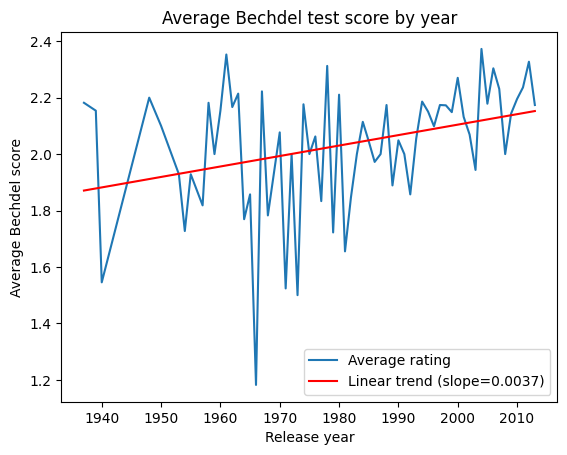

In [11]:
df_year_mbechdel = df_movies_bechdel.groupby('year')['bechdel_score'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_mbechdel = df_year_mbechdel.rename(columns={'bechdel_score':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_mbechdel['year'],df_year_mbechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_mbechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_mbechdel['year'], slope*df_year_mbechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


By these results, we observe that average Bechdel test scores have increased over the years, as indicated by the positive slope of the regression line. The Pearson correlation coefficient (r=0.3294) suggests a moderate positive relationship between the year and the Bechdel test results. However, the r^2 value (10.85%) implies that most of the variance (~89%) in Bechdel test results is explained by factors other than time, such as genre, budget, or country of origin.

The p-value (0.00785) is statistically significant at the α=0.05 level, providing strong evidence that this relationship is unlikely to have occurred due to chance. Nevertheless, the effect size is relatively modest, so we should interpret the results with caution.

Next, we analyze the relationship between the year and average Bechdel test scores using the Bechdel test result database. Since this database contains more films than the merged database, it offers a broader dataset for analysis. To maintain consistency and reduce biases, we apply the same procedure as before: removing all years with fewer than 10 films. This ensures that our results are based on a sufficiently representative sample for each year.

In [12]:
year_counts = df_bechdel['year'].value_counts()

# Filter years with at least 10 films
valid_years = year_counts[year_counts >= 10].index

# Keep only rows where the 'year' is in the valid_years list
year_filtered_df = df_bechdel[df_bechdel['year'].isin(valid_years)]

year_filtered_df.head()

df_bechdel = year_filtered_df

Pearson Correlation Coefficient: 0.6415, p-value: 4.896996829119613e-13, intercept=-15.79


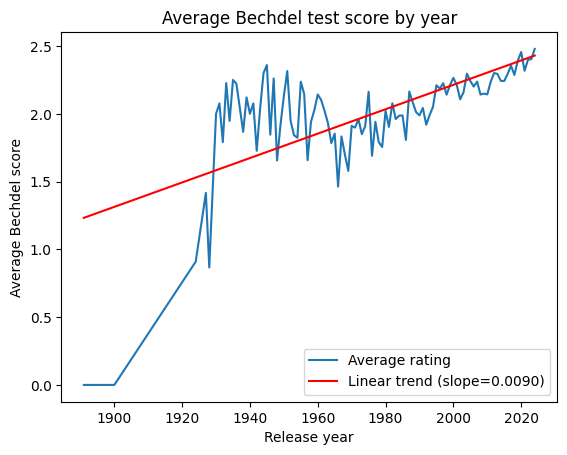

In [13]:
df_year_bechdel = df_bechdel.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})


slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel['year'],df_year_bechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_bechdel['year'], slope*df_year_bechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


In the original Bechdel Test database, we observe a slope that is 2.4 times steeper, a lower intercept, and an r-value of approximately 0.64. This indicates a notably stronger correlation between Bechdel Test results and release year compared to the merged database. It is surprising that reducing the dataset to only films present in both databases yields such a different correlation.

A comparison of the graphs suggests that the merged database contains fewer films from the late 1800s and early 1900s. This discrepancy may explain the variation in correlation, and it can be easily verified:

All unselected films: Pearson Correlation Coefficient: 0.6380, p-value: 7.160298928035548e-13, intercept=-16.42
Unselected films after 1920: Pearson Correlation Coefficient: 0.5207, p-value: 3.880360392507303e-08, intercept=-8.93
Unselected films before 2020: Pearson Correlation Coefficient: 0.6136, p-value: 2.982321169818847e-11, intercept=-16.50


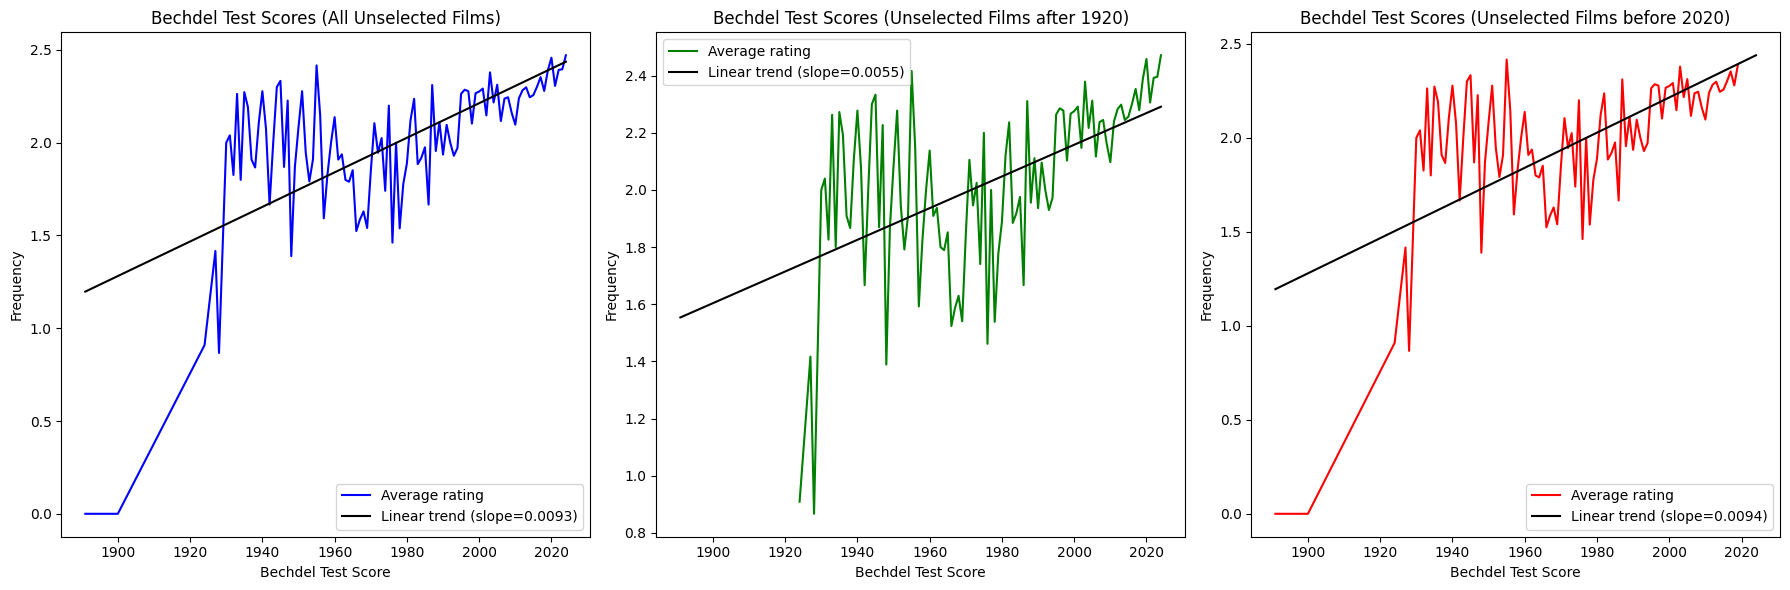

In [14]:
df_bechdel_notmerged=df_bechdel[~df_bechdel['title'].isin(df_movies_bechdel['title'])]

df_year_bechdel_n = df_bechdel_notmerged.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel_n = df_year_bechdel_n.rename(columns={'rating':'avg_bechdel_score'})

# Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: All unselected films (Bechdel scores)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n['year'],df_year_bechdel_n['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n, x='year', y='avg_bechdel_score', label='Average rating', ax=axes[0], color='blue')
axes[0].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[0].set_title('Bechdel Test Scores (All Unselected Films)')
axes[0].set_xlabel('Bechdel Test Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

print(f"All unselected films: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 2: Unselected films excluding those before 1920
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('1920<year')['year'],df_year_bechdel_n.query('1920<year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('1920<year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[1], color='green')
axes[1].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[1].set_title('Bechdel Test Scores (Unselected Films after 1920)')
axes[1].set_xlabel('Bechdel Test Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

print(f"Unselected films after 1920: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 3: Unselected films excluding those after 2020
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('2020>year')['year'],df_year_bechdel_n.query('2020>year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('2020>year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[2], color='red')
axes[2].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[2].set_title('Bechdel Test Scores (Unselected Films before 2020)')
axes[2].set_xlabel('Bechdel Test Score')
axes[2].set_ylabel('Frequency')
axes[2].legend()

print(f"Unselected films before 2020: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We observe that films released before 1920 have a lower average Bechdel test score and significantly influence the correlation between release year and the average Bechdel score. This is particularly noteworthy as it suggests that considerable attention was paid to early cinema when compiling the Bechdel test database, including films from the industry's origins. This focus on early films could help explain the stronger correlation observed in the earlier years, a trend that is not evident in our merged dataset.

Based on this analysis, we can propose the following two theories:

The Bechdel test results have improved over time, suggesting a gradual shift towards more meaningful female representation in films. Women were largely absent from lead roles in the early years of cinema, as evidenced by the lower Bechdel test scores for films released before 1920.

These findings highlight both the historical progression of women's roles in film and the growing significance of the Bechdel test as a measure of female representation in cinema.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [15]:
df_movies_bechdel['countries'].value_counts()

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2382
EU     389
AS     121
OC      20
SA       4
Name: count, dtype: int64

In [46]:
# Step 1: Filter years with at least 5 movies per region
region_threshold = 5  # Minimum number of movies per year for each region

# Group by continent and year, then count movies
region_year_counts = df_movies_bechdel.groupby(['continent', 'year']).size().reset_index(name='movie_count')

# Filter years that have at least the threshold number of movies for each region
valid_years_per_region = region_year_counts[region_year_counts['movie_count'] >= region_threshold].groupby('continent')['year'].apply(set)

# Step 2: Keep only rows where the 'year' is valid for the respective region
def filter_by_region_and_year(row):
    return row['year'] in valid_years_per_region.get(row['continent'], set())

df_movies_bechdel_filtered = df_movies_bechdel[df_movies_bechdel.apply(filter_by_region_and_year, axis=1)]

# Check the filtered dataset
print(df_movies_bechdel_filtered['year'].value_counts())


year
2010.0    160
2009.0    160
2011.0    156
2008.0    130
2006.0    123
         ... 
1962.0      8
1950.0      8
1965.0      8
1966.0      7
1975.0      6
Name: count, Length: 64, dtype: int64


There is a noticeable underrepresentation of non-North American and non-European films in the Bechdel test database. This disparity can be attributed to the test's popularity being primarily concentrated in North America, with limited focus on international films in the analysis.

For clarity and a more focused visualization, we will restrict the plots to films from North America, Europe, and Asia.

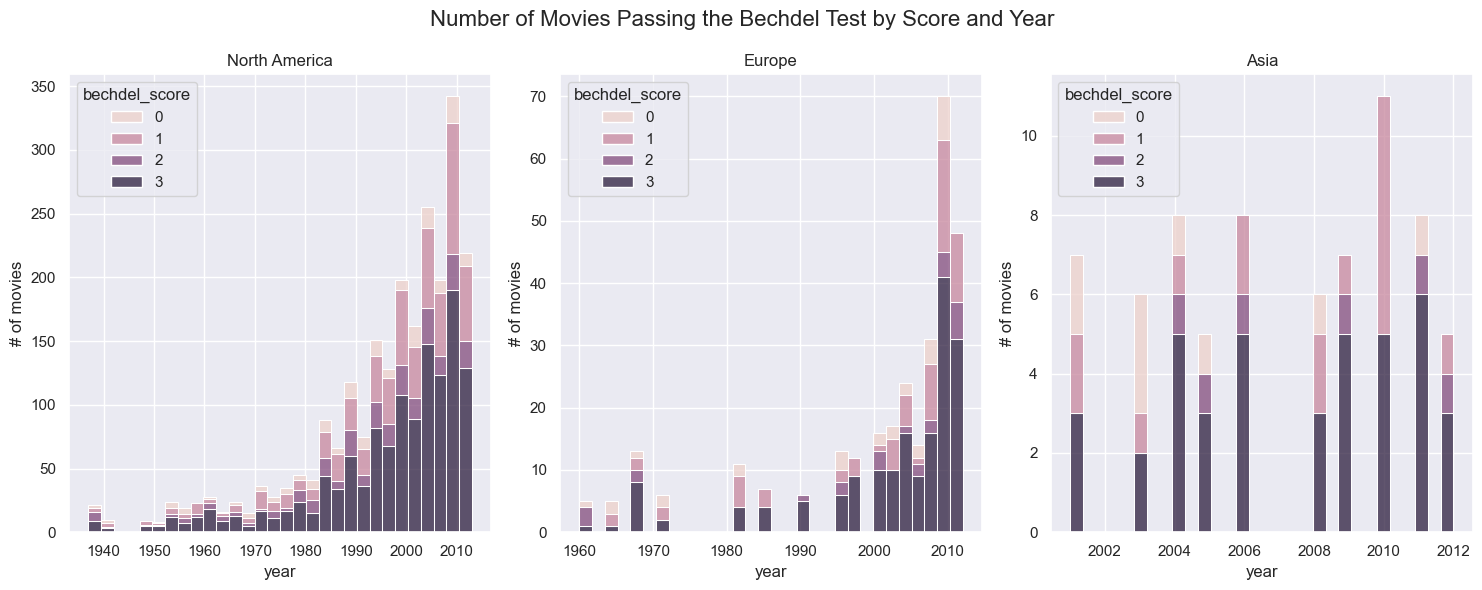

In [47]:
# Update the data source for the plot
df_movies_bechdel = df_movies_bechdel_filtered

# Create the histograms
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]
).set(title='North America', ylabel='# of movies')

sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]
).set(title='Europe', ylabel='# of movies')

sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]
).set(title='Asia', ylabel='# of movies')

plt.tight_layout()
plt.show()


As observed previously, the number of films passing the Bechdel test has increased, but we cannot draw definitive conclusions about the proportion of films passing or failing the test.

Similar to our earlier analysis, we will now calculate the averages by continent. Our first step will be to identify the continents for which we have a significant correlation between the year of release and the average Bechdel test score. This will be assessed using Pearson regression.

In [48]:
# First, we will calculate the average Bechdel score for each region by year
df_avg_continent = df_movies_bechdel_filtered.pivot_table(
    index='year', 
    columns='continent', 
    values='bechdel_score', 
    aggfunc='mean'
).reset_index()

# Rename columns to be more descriptive
df_avg_continent.columns = ['year'] + [f'avg_bechdel_score_{col}' for col in df_avg_continent.columns[1:]]

# Pearson correlation for North America
r_score_NA, p_score_NA = stats.pearsonr(
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'year'], 
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'avg_bechdel_score_NA']
)
print(f'Pearson regression NA r-score: {r_score_NA:.4f}, p-score: {p_score_NA}')

# Pearson correlation for Europe
r_score_EU, p_score_EU = stats.pearsonr(
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'year'], 
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'avg_bechdel_score_EU']
)
print(f'Pearson regression EU r-score: {r_score_EU:.4f}, p-score: {p_score_EU}')

# Pearson correlation for Asia
r_score_AS, p_score_AS = stats.pearsonr(
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(), 'year'], 
    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(), 'avg_bechdel_score_AS']
)
print(f'Pearson regression AS r-score: {r_score_AS:.4f}, p-score: {p_score_AS}')


Pearson regression NA r-score: 0.2534, p-score: 0.04337047266131375
Pearson regression EU r-score: 0.4190, p-score: 0.03710572289125154
Pearson regression AS r-score: 0.6153, p-score: 0.05828455859750432


We are unable to perform a linear regression for Europe nor Asia due to very high p-values. This is likely a result of the small number of films from these regions in the Bechdel test database, which limits the statistical power for such analyses.

For North America: Pearson Correlation Coefficient: 0.2534, p-value: 0.04337047266131387, intercept=-4.04
For Europe: Pearson Correlation Coefficient: 0.4190, p-value: 0.03710572289125137, intercept=-20.77
For Asia: Pearson Correlation Coefficient: 0.6153, p-value: 0.05828455859750425, intercept=-149.99


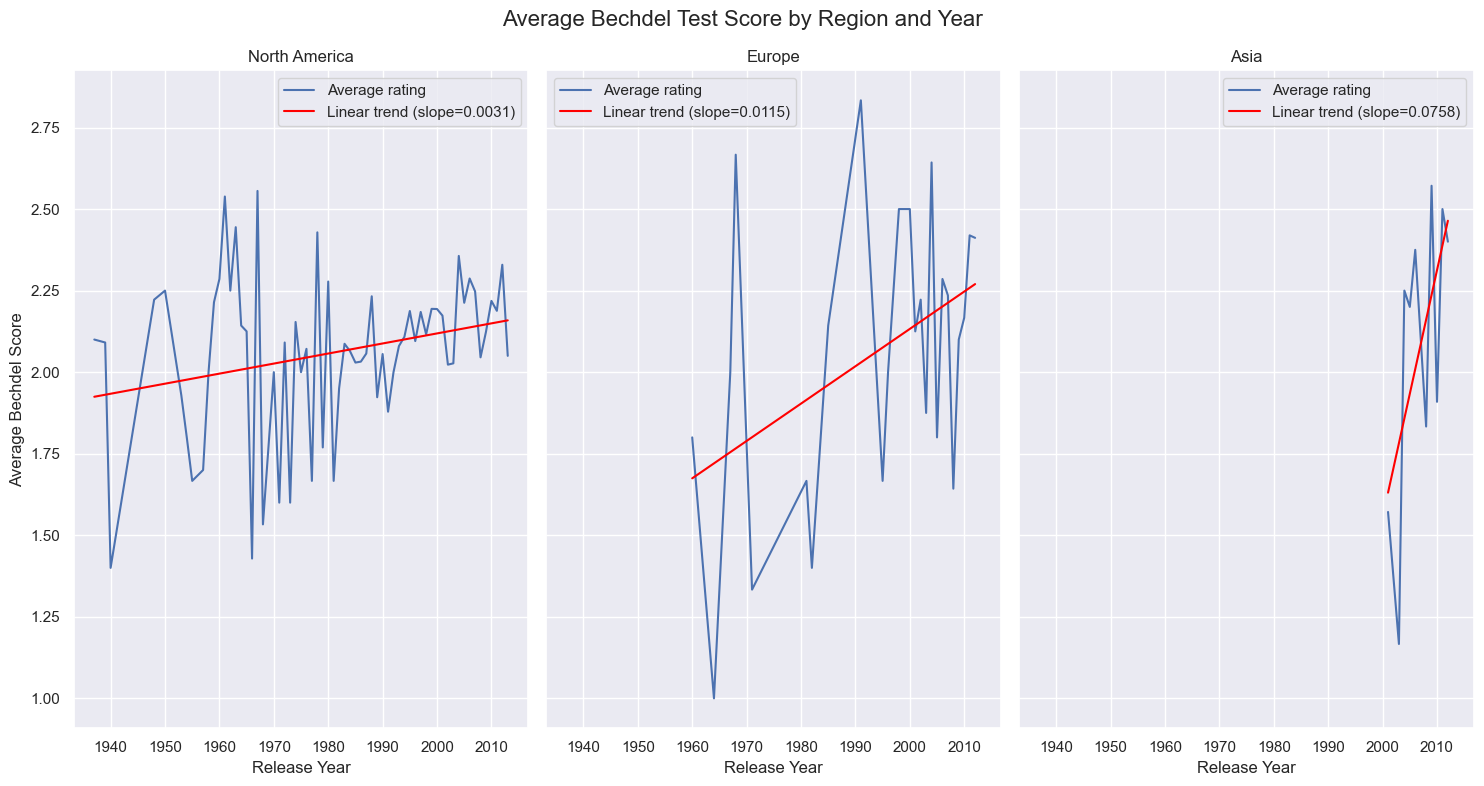

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_theme()

# Create subplots for each region (NA, EU, AS)
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

fig.suptitle('Average Bechdel Test Score by Region and Year', fontsize=16)

# North America Plot
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_NA', label='Average rating', ax=axes[0]).set(title='North America', ylabel='Average Bechdel Score')

# Filter out NaN values for the regression line
df_na = df_avg_continent[df_avg_continent['avg_bechdel_score_NA'].notna()]

# Apply linear regression only for valid data points
if len(df_na) > 0:
    slope_NA, intercept_NA, rvalue_NA, pvalue_NA, stderr_NA = stats.linregress(df_na['year'], df_na['avg_bechdel_score_NA'])
    print(f"For North America: Pearson Correlation Coefficient: {rvalue_NA:.4f}, p-value: {pvalue_NA}, intercept={intercept_NA:.2f}")

    # Plot the trendline
    axes[0].plot(df_na['year'], slope_NA * df_na['year'] + intercept_NA, color='red', label=f'Linear trend (slope={slope_NA:.4f})')

axes[0].set_xlabel('Release Year')
axes[0].set_ylabel('Average Bechdel Score')
axes[0].legend()

# Europe Plot
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_EU', label='Average rating', ax=axes[1]).set(title='Europe', ylabel='Average Bechdel Score')

# Filter out NaN values for the regression line
df_eu = df_avg_continent[df_avg_continent['avg_bechdel_score_EU'].notna()]

# Apply linear regression only for valid data points
if len(df_eu) > 0:
    slope_EU, intercept_EU, rvalue_EU, pvalue_EU, stderr_EU = stats.linregress(df_eu['year'], df_eu['avg_bechdel_score_EU'])
    print(f"For Europe: Pearson Correlation Coefficient: {rvalue_EU:.4f}, p-value: {pvalue_EU}, intercept={intercept_EU:.2f}")

    # Plot the trendline
    axes[1].plot(df_eu['year'], slope_EU * df_eu['year'] + intercept_EU, color='red', label=f'Linear trend (slope={slope_EU:.4f})')

axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Average Bechdel Score')
axes[1].legend()

# Asia Plot
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_AS', label='Average rating', ax=axes[2]).set(title='Asia', ylabel='Average Bechdel Score')

# Filter out NaN values for the regression line
df_as = df_avg_continent[df_avg_continent['avg_bechdel_score_AS'].notna()]

# Apply linear regression only for valid data points
if len(df_as) > 0:
    slope_AS, intercept_AS, rvalue_AS, pvalue_AS, stderr_AS = stats.linregress(df_as['year'], df_as['avg_bechdel_score_AS'])
    print(f"For Asia: Pearson Correlation Coefficient: {rvalue_AS:.4f}, p-value: {pvalue_AS}, intercept={intercept_AS:.2f}")

    # Plot the trendline
    axes[2].plot(df_as['year'], slope_AS * df_as['year'] + intercept_AS, color='red', label=f'Linear trend (slope={slope_AS:.4f})')

axes[2].set_xlabel('Release Year')
axes[2].set_ylabel('Average Bechdel Score')
axes[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


As anticipated, the limited number of European and Asian films in the database prevented us from obtaining meaningful results for these regions. Consequently, the Bechdel test results can only be reliably analyzed for North American films.

The overrepresentation of American films in the Bechdel test database means that the results for the entire dataset are likely skewed and not fully representative of global trends, though they do offer insights specific to North America.

Nonetheless, as expected, the trend observed for North American films closely aligns with the findings from the merged Bechdel test dataset.

### Female actresses

We will here analyze the impact of the number of female actresses in a movie. Either By genre, or its relatedness to the Bechdel test

In [19]:
#For readability, we are going to set the wikipedia id as index

column_names = ['movie_freebase_id', 'release_date','character_name','birth','gender','character_height', 'actor_ethnicity',
                'actor_name','actor_age', 'actor_gender_freebase_id','character_freebase_id','freebase_character_map']

df_characters=pd.read_csv(data_folder+'/character.metadata.tsv', sep= '\t', names = column_names)

df_characters.index.name='wikipedia_movie_id'

df_characters.sample(5)

,movie_freebase_id,release_date,character_name,birth,gender,character_height,actor_ethnicity,actor_name,actor_age,actor_gender_freebase_id,character_freebase_id,freebase_character_map
wikipedia_movie_id,,,,,,,,,,,,
7787845,/m/0kvh49,1998-10-30,Teenage Judith,1979-10-04,F,1.57,/m/0xnvg,Rachael Leigh Cook,19.0,/m/0cs4wc4,/m/0glkjjb,/m/01x9_8
3395527,/m/099bhp,2001,NaN,1952-11-14,M,NaN,NaN,Bill Farmer,48.0,/m/02t9_2_,NaN,/m/05rtpn
15210434,/m/03hlzbp,2008-04-18,NaN,1970-11-07,M,1.87,NaN,Morgan Spurlock,37.0,/m/040ncvc,NaN,/m/035sc2
13697816,/m/03cfd9n,1965,NaN,1931-04-14,M,NaN,NaN,Kenneth Cope,33.0,/m/040l8jd,NaN,/m/03slgw
1525968,/m/0581w_,2000-09-04,Father Ryan,NaN,M,NaN,NaN,Russell Dixon,NaN,/m/0h2pg7k,/m/0l3zw8p,/m/0bjc8fz


#### Connection between the number of lead female actresses and the Bechdel test score

In [27]:
# Count the number of female characters
female_counts = df_characters[df_characters['gender'] == 'F'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_female_actresses')

# Count the number of male characters
male_counts = df_characters[df_characters['gender'] == 'M'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_male_actors')

# Merge the counts into df_movies_bechdel, ensuring all rows from df_movies_bechdel are retained (left join)
df_movies_bechdel_characters = df_movies_bechdel.merge(female_counts, on='wikipedia_movie_id', how='left')
df_movies_bechdel_characters = df_movies_bechdel_characters.merge(male_counts, on='wikipedia_movie_id', how='left')

# Fill NaN values with 0 (in case there are films with no male or female characters)
df_movies_bechdel_characters['nbr_female_actresses'] = df_movies_bechdel_characters['nbr_female_actresses'].fillna(0)
df_movies_bechdel_characters['nbr_male_actors'] = df_movies_bechdel_characters['nbr_male_actors'].fillna(0)

# Calculate the proportion of female roles with respect to total roles (female + male)
df_movies_bechdel_characters['female_proportion'] = df_movies_bechdel_characters['nbr_female_actresses'] / (df_movies_bechdel_characters['nbr_female_actresses'] + df_movies_bechdel_characters['nbr_male_actors'])


# Display a sample of the updated dataframe
df_movies_bechdel_characters.sample(5)


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,bechdel_score,imdbid,continent,nbr_female_actresses,nbr_male_actors,female_proportion
1621,1469880,/m/0540f_,Smoke Signals,1998-01-16,NaN,89.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0556j8"": ""Buddy film"", ""/m/0219x_"": ""Indi...",1998.0,3,0120321,NA,3.0,5.0,0.375000
319,35729649,/m/0gz6b6g,End of Watch,2012-09-08,36375000.0,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2012.0,3,1855199,NA,7.0,8.0,0.466667
2465,2249951,/m/06z5rr,Deadly Friend,1986-10-10,8988731.0,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1986.0,2,0090917,NA,3.0,5.0,0.375000
2082,27652539,/m/0c3wq27,Cedar Rapids,2011-01-23,6861102.0,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",2011.0,1,1477837,NA,6.0,11.0,0.352941
1652,11643011,/m/02rmhgg,Madeline,1998-07-10,36967750.0,88.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0hqxf"": ""Family Film"", ""/m/0bj8m2"": ""Chil...",1998.0,3,0123987,EU,12.0,4.0,0.750000


We will begin by creating a scatter plot to examine the relationship between a film's Bechdel test score and the number of female actors, and analyzing their Pearson correlation results.

Pearson correlation: 0.3892224824369585, p-value: 1.2349539514413843e-107


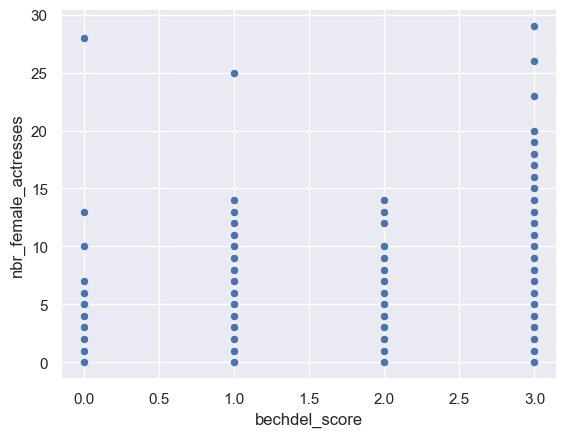

In [28]:
sns.scatterplot(data=df_movies_bechdel_characters, y='nbr_female_actresses',x='bechdel_score')

valid_data = df_movies_bechdel_characters[df_movies_bechdel_characters['nbr_female_actresses'].notna()]

correlation, p_value = stats.pearsonr(valid_data['nbr_female_actresses'], valid_data['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

The Pearson correlation coefficient of 0.389 indicates a moderate positive relationship between the Bechdel test score and the number of female actors in a film. This suggests that as the number of female actors in a film increases, the Bechdel test score tends to rise as well. The p-value of 1.23e-107 is exceptionally small, meaning that this correlation is highly statistically significant. In other words, the observed relationship is almost certainly not due to random chance, providing strong evidence for a meaningful link between the number of female actors and the Bechdel test score in the films analyzed.

However, it is important to note that this relationship may not be entirely independent, and further analysis is needed to account for the changing representation of female actresses over time.

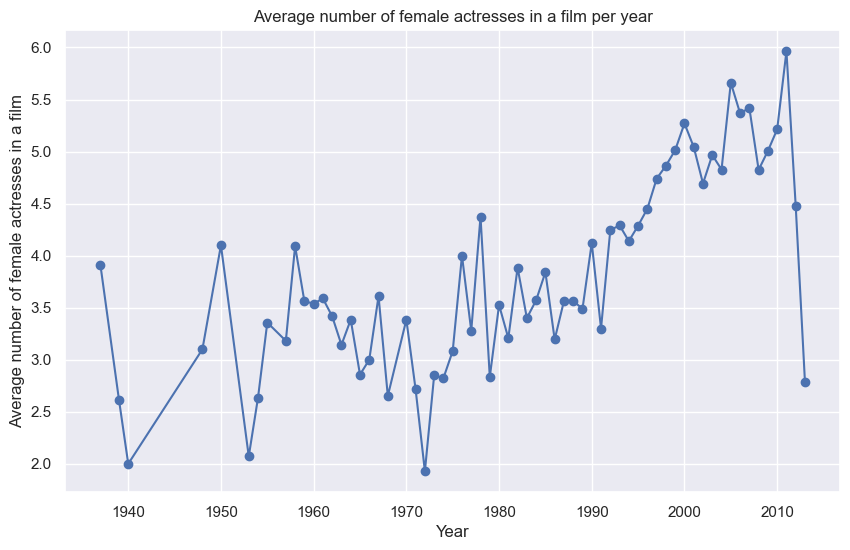

Pearson correlation: 0.7100491367944652, p-value: 5.0301977668067976e-11


,year,nbr_female_actresses
0,1937.0,3.909091
1,1939.0,2.615385
2,1940.0,2.000000
3,1948.0,3.100000
4,1950.0,4.100000


In [29]:


df_female_year = df_movies_bechdel_characters.groupby('year')['nbr_female_actresses'].agg('mean').reset_index()

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_female_year['year'], df_female_year['nbr_female_actresses'], marker='o', linestyle='-', color='b')
plt.title('Average number of female actresses in a film per year')
plt.xlabel('Year')
plt.ylabel('Average number of female actresses in a film')
plt.grid(True)
plt.show()

correlation,p_value =stats.pearsonr(df_female_year['year'],df_female_year['nbr_female_actresses'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

df_female_year.head()


The Pearson correlation coefficient of 0.71 indicates a strong positive relationship between the year of release and the average number of female actresses per film. This suggests that as time progresses, the number of female actresses in films tends to increase. The p-value of 5.03e-11 is extremely small, indicating that this relationship is highly statistically significant and not due to random chance. This provides strong evidence that the representation of female actresses in films has grown over the years, supporting the idea of increasing gender diversity in film roles over time.

Let's see what the relationship between the Bechdel test score and the proportion of female actresses to male actors relate.

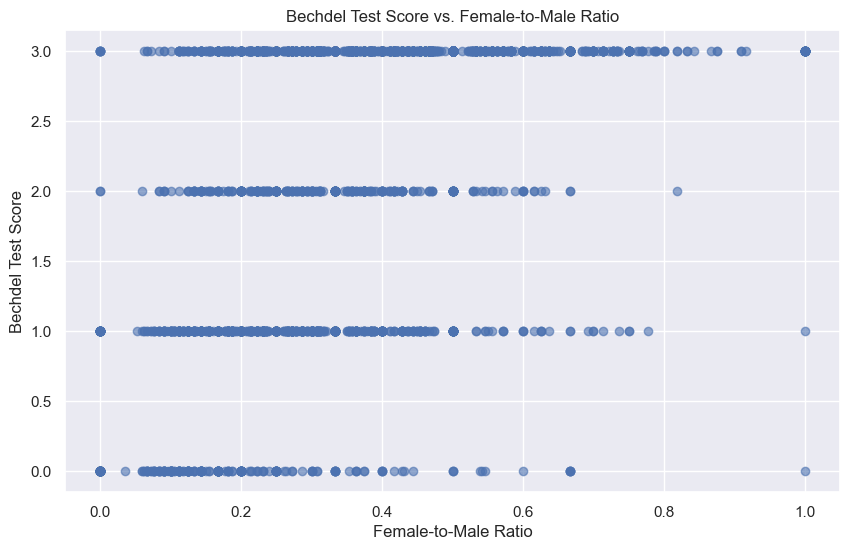

Pearson correlation: 0.4879519419622532, p-value: 4.3646243258047104e-175


In [30]:
# Step 1: Plot the scatterplot of Bechdel test score vs. female-to-male ratio
plt.figure(figsize=(10, 6))
plt.scatter(df_movies_bechdel_characters['female_proportion'], df_movies_bechdel_characters['bechdel_score'], color='b', alpha=0.6)
plt.title('Bechdel Test Score vs. Female-to-Male Ratio')
plt.xlabel('Female-to-Male Ratio')
plt.ylabel('Bechdel Test Score')
plt.grid(True)
plt.show()


# Remove rows with NaN or inf values in both 'female_proportion' and 'bechdel_score'
df_movies_bechdel_characters_clean = df_movies_bechdel_characters.dropna(subset=['female_proportion', 'bechdel_score'])
df_movies_bechdel_characters_clean = df_movies_bechdel_characters_clean[~df_movies_bechdel_characters_clean[['female_proportion', 'bechdel_score']].isin([float('inf'), -float('inf')]).any(axis=1)]

# Step 2: Calculate the Pearson correlation
correlation, p_value = stats.pearsonr(df_movies_bechdel_characters_clean['female_proportion'], df_movies_bechdel_characters_clean['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")


The analysis reveals a moderate positive correlation (0.488) between the proportion of female roles in a film and its Bechdel test score, suggesting that films with a higher representation of female characters tend to score better on the Bechdel test. The extremely low p-value (4.36e-175) confirms that this relationship is highly statistically significant, meaning it's unlikely to be due to chance. In essence, films with more female roles are more likely to pass the Bechdel test, reflecting a meaningful link between gender representation and the test's criteria

Now, let's see how this proportion has evolved over the years:

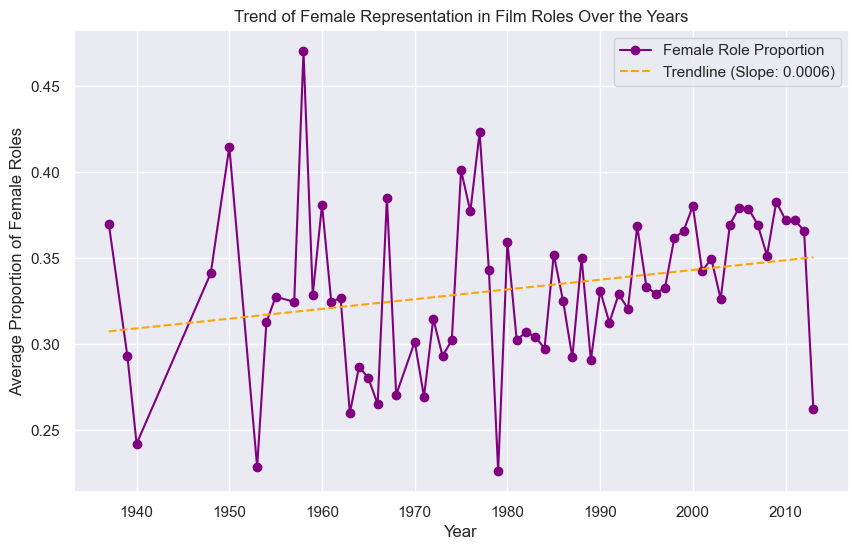

Slope: 0.0006, Intercept: -0.7893
Pearson correlation (r): 0.24, p-value: 5.29e-02


In [39]:
from scipy.stats import linregress

# Group by year and calculate the average female proportion for each year
df_yearly_female_proportion = df_movies_bechdel_characters.groupby('year')['female_proportion'].mean().reset_index()

# Step 1: Perform Linear Regression using stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(
    df_yearly_female_proportion['year'], 
    df_yearly_female_proportion['female_proportion']
)
trendline = intercept + slope * df_yearly_female_proportion['year']

# Step 2: Plot the data and trendline
plt.figure(figsize=(10, 6))
plt.plot(
    df_yearly_female_proportion['year'], 
    df_yearly_female_proportion['female_proportion'], 
    marker='o', linestyle='-', color='purple', label='Female Role Proportion'
)
plt.plot(
    df_yearly_female_proportion['year'], 
    trendline, 
    color='orange', linestyle='--', label=f'Trendline (Slope: {slope:.4f})'
)
plt.title('Trend of Female Representation in Film Roles Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Proportion of Female Roles')
plt.grid(True)
plt.legend()
plt.show()

# Step 3: Display regression and correlation details
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")
print(f"Pearson correlation (r): {r_value:.2f}, p-value: {p_value:.2e}")


The analysis shows a weak positive correlation (0.10) between the female-to-male role proportion and the year, suggesting a slight increase in female roles over time. The very small p-value (6.06e-08) indicates that this correlation is statistically significant, though the trend is weak. This implies that while there is a measurable shift towards more female roles in films, the change is modest and not very pronounced.

Let's examine the relationship between the average number of female actresses in a film and the female proportion.

Pearson correlation: 0.6048087886169952, p-value: 8.938378270642034e-292


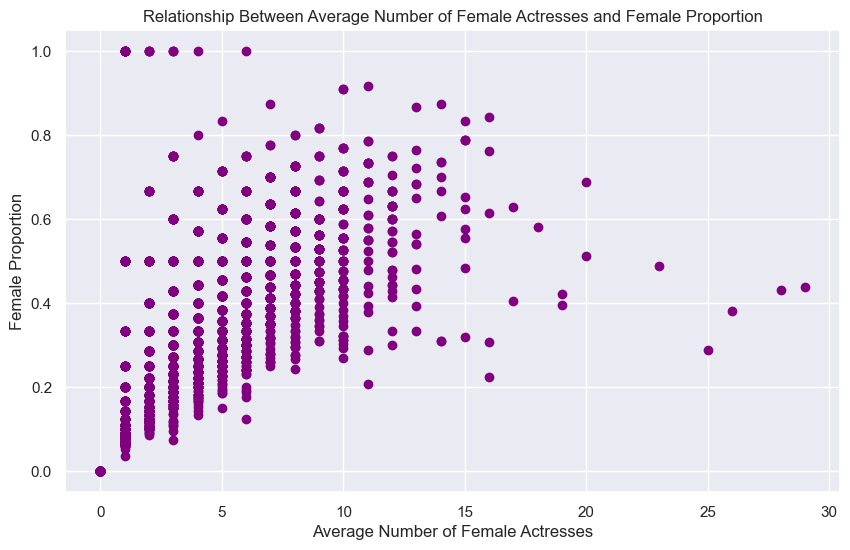

In [32]:
# Remove rows with NaN or infinite values in either 'nbr_female_actresses' or 'female_proportion'
df_movies_bechdel_characters_clean = df_movies_bechdel_characters.dropna(subset=['nbr_female_actresses', 'female_proportion'])
df_movies_bechdel_characters_clean = df_movies_bechdel_characters_clean[~df_movies_bechdel_characters_clean[['nbr_female_actresses', 'female_proportion']].isin([np.inf, -np.inf]).any(axis=1)]

# Calculate the correlation between the average number of female actresses and the female proportion
correlation, p_value = stats.pearsonr(df_movies_bechdel_characters_clean['nbr_female_actresses'], df_movies_bechdel_characters_clean['female_proportion'])

# Print the correlation and p-value
print(f"Pearson correlation: {correlation}, p-value: {p_value}")

# Optionally, plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_movies_bechdel_characters_clean['nbr_female_actresses'], df_movies_bechdel_characters_clean['female_proportion'], color='purple')
plt.title('Relationship Between Average Number of Female Actresses and Female Proportion')
plt.xlabel('Average Number of Female Actresses')
plt.ylabel('Female Proportion')
plt.grid(True)
plt.show()


The Pearson correlation of 0.605 indicates a moderate positive relationship between the average number of female actresses per film and the female proportion in films. This suggests that as the number of female actresses in a film increases, the proportion of female roles relative to male roles tends to rise as well. The p-value of 8.94e-292 is extremely small, which means this correlation is highly statistically significant, strongly suggesting that this relationship is not due to random chance. These findings provide evidence of a meaningful association between the number of female actresses and the representation of female roles in films.

#### Propensity Score Matching
We will now perform propensity score matching to assess whether an increase in the number of actresses in a film has a measurable impact on its Bechdel test score.

The treatment will be defined as having a number of actresses greater than the mean for each film.

In [ ]:
# Step 1: Count the number of female actresses per film
female_counts = df_characters[df_characters['gender'] == 'F'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_female_actresses')

# Step 2: Merge the female counts with the movies dataframe
df_movies_bechdel_characters = df_movies_bechdel.merge(female_counts, on='wikipedia_movie_id', how='left')

# Step 3: Fill NaN values with 0 (if any films do not have female actresses)
df_movies_bechdel_characters['nbr_female_actresses'] = df_movies_bechdel_characters['nbr_female_actresses'].fillna(0)

# Step 4: Calculate the average number of female actresses in a film
average_female_actresses = df_movies_bechdel_characters['nbr_female_actresses'].mean()

print(f"Average number of female actresses per film: {average_female_actresses}")


Average number of female actresses per film: 4.514700912470429


In [ ]:
df_movies_bechdel_characters.head()

,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,bechdel_score,imdbid,continent,nbr_female_actresses,treatment
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,3,0228333,NA,6.0,1
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,3,0097499,EU,3.0,0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,3,0058331,NA,6.0,1
3,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1989.0,3,0097790,NA,6.0,1
4,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",1968.0,3,0063642,NA,2.0,0


We will now perform propensity score matching to see if increasing the number of actresses in a film actually has an impact on the bechdel test

In [ ]:
# Step 1: Define the Treatment Variable
mean_female_actresses = df_movies_bechdel_characters['nbr_female_actresses'].mean()  # Calculate the mean number of female actresses
df_movies_bechdel_characters['treatment'] = (df_movies_bechdel_characters['nbr_female_actresses'] > mean_female_actresses).astype(int)

# Step 2: Select Covariates for the Propensity Score Model
covariates = ['runtime', 'revenue', 'female_proportion', 'year']  # Example covariates (adjust as needed)

# Prepare the data for logistic regression
X = df_movies_bechdel_characters[covariates]
y = df_movies_bechdel_characters['treatment']

# Step 3: Handle Missing Values
# Impute missing values for numerical columns (mean for 'runtime', 'revenue', 'female_proportion')
num_imputer = SimpleImputer(strategy='mean')
X[['runtime', 'revenue', 'female_proportion']] = num_imputer.fit_transform(X[['runtime', 'revenue', 'female_proportion']])

# Impute 'year' with the most frequent value (mode)
year_imputer = SimpleImputer(strategy='most_frequent')
df_movies_bechdel_characters['year'] = year_imputer.fit_transform(df_movies_bechdel_characters[['year']])

# Step 4: Check for missing values
print(X.isnull().sum())  # This will show how many missing values are in each column

# Step 5: Standardize the features (optional but recommended for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Logistic Regression to Estimate the Propensity Score
# Perform logistic regression to calculate the propensity score
logreg = LogisticRegression()
logreg.fit(X_scaled, y)

# Add the estimated propensity scores to the DataFrame
df_movies_bechdel_characters['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

# Step 7: Matching Films Based on the Propensity Score
# Now you can perform matching using a nearest-neighbor approach, or use packages like `statsmodels` or `pandas` to perform matching.
# For simplicity, let's show how you can just inspect films based on propensity score

treated = df_movies_bechdel_characters[df_movies_bechdel_characters['treatment'] == 1]
control = df_movies_bechdel_characters[df_movies_bechdel_characters['treatment'] == 0]

# Example: Find the closest control film for each treated film based on propensity score
# This can be done using various matching techniques like nearest-neighbor matching

# Example of inspecting the treated films with their propensity scores
treated[['title', 'propensity_score']].sort_values('propensity_score', ascending=False)

# Step 8: (Optional) Analyze the Effect of the Treatment
# You can now analyze the effect of the treatment (more female actresses) on the Bechdel score, using matched samples.
# For example, you can compare the Bechdel score between treated and control groups after matching.


runtime              0
revenue              0
female_proportion    0
year                 0
dtype: int64


C:\Users\orloj\AppData\Local\Temp\ipykernel_1884\762832065.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['runtime', 'revenue', 'female_proportion']] = num_imputer.fit_transform(X[['runtime', 'revenue', 'female_proportion']])


,title,propensity_score
1444,Precious: Based on the Novel Push by Sapphire,0.994297
2103,Secret Places,0.993042
1175,Cracks,0.991334
1172,Tinker Bell,0.990558
733,Beautiful,0.990094
...,...,...
2417,Fast Times at Ridgemont High,0.098002
2033,Cleopatra Jones,0.094724
2620,Lady and the Tramp,0.092417
860,A Day at the Races,0.084317


We will now match treated and untreated films and check the treatment effect

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Perform Nearest-Neighbor Matching based on Propensity Score
# Combine treated and untreated films into one DataFrame
df_movies_bechdel_characters['matched_treatment'] = -1  # Initialize a column for matched treatment group

# Get treated and control films
treated = df_movies_bechdel_characters[df_movies_bechdel_characters['treatment'] == 1]
control = df_movies_bechdel_characters[df_movies_bechdel_characters['treatment'] == 0]

# Use Nearest Neighbors to find the closest match for each treated film
# We match based on the propensity score
nn = NearestNeighbors(n_neighbors=1)  # Find the closest neighbor
nn.fit(control[['propensity_score']])  # Fit on the control group

# Find the closest control film for each treated film
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Add the matched control film's index to the treated films
treated['matched_treatment'] = control.iloc[indices.flatten()].index

# Step 2: Combine matched treated and control films into a single DataFrame
matched_df = pd.concat([treated, control.loc[treated['matched_treatment']]], axis=0)

# Step 3: Analyze the Treatment Effect
# You can now analyze the effect of the treatment on the Bechdel score. For example:
treated_mean_bechdel = matched_df[matched_df['treatment'] == 1]['bechdel_score'].mean()
control_mean_bechdel = matched_df[matched_df['treatment'] == 0]['bechdel_score'].mean()

# Display the treatment effect (difference in mean Bechdel scores)
print(f"Mean Bechdel score for treated films: {treated_mean_bechdel}")
print(f"Mean Bechdel score for control films: {control_mean_bechdel}")
print(f"Treatment Effect (difference in means): {treated_mean_bechdel - control_mean_bechdel}")


Mean Bechdel score for treated films: 2.543942992874109
Mean Bechdel score for control films: 2.3333333333333335
Treatment Effect (difference in means): 0.2106096595407756


C:\Users\orloj\AppData\Local\Temp\ipykernel_1884\3050231322.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated['matched_treatment'] = control.iloc[indices.flatten()].index


In [ ]:
# Step 1: Extract Bechdel scores for treated and control films
treated_bechdel_scores = treated['bechdel_score']
control_bechdel_scores = control['bechdel_score']

# Step 2: Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(treated_bechdel_scores, control_bechdel_scores)

# Step 3: Interpret the p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"The treatment effect is statistically significant (p-value: {p_value})")
else:
    print(f"The treatment effect is not statistically significant (p-value: {p_value})")


The treatment effect is statistically significant (p-value: 2.821133677342157e-85)


In this analysis, we explored the relationship between the number of female actresses in a film and its Bechdel score using propensity score matching and a t-test. We defined the treatment as films with more than the mean number of female actresses and then compared the Bechdel scores of treated and control films.

Key findings:

After performing propensity score matching, we found that the treatment (more female actresses) had a statistically significant effect on the Bechdel score.
The p-value from the t-test was extremely small (2.82×10^−85), indicating that the difference in Bechdel scores between the treated and control groups is highly unlikely to be due to chance.

The results suggest that films with a higher number of female actresses tend to have higher Bechdel scores, reinforcing the idea that increased female representation in film correlates with better gender representation as measured by the Bechdel test.

We use the code to mix film database and Bechdel once again

In [ ]:
#We are going to create a database where we merge the bechdel and the movie database, so that we can have all of the information of those films 
# in one single dataframe. We will merge it on year and title, to avoid having one title of he Bechdel database to many movies in the movie database.

# Convert release_date to datetime format (if it's not already in datetime)
df_clean_data_success['release_date'] = pd.to_datetime(df_clean_data_success['release_date'], errors='coerce')

# Extract the year from the release_date column
df_clean_data_success['year'] = df_clean_data_success['release_date'].dt.year

# Merge the datasets by 'title' and 'year'
df_succes_bechdel = pd.merge(df_clean_data_success, df_bechdel, how='inner', on=['title', 'year'])



df_succes_bechdel = df_succes_bechdel.rename(columns={'rating_y':'bechdel_score'})
df_succes_bechdel = df_succes_bechdel.drop_duplicates(['title','Wiki_ID'])

print(f'The combined Bechdel and CMU Movies database has {df_succes_bechdel.shape[0]} films')

df_succes_bechdel.head()

The combined Bechdel and CMU Movies database has 1833 films


,Unnamed: 0.1,Unnamed: 0,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,...,budget,Net_revenue,rating_x,BoxOfficeRank,RatingRank,SuccessMetric,year,id,bechdel_score,imdbid
0,0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,28000000.0,-13989168.0,4.850459,0.093178,0.089868,0.091523,2001.0,333,3,0228333
1,2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",...,9000000.0,1161099.0,7.450000,0.323627,0.903072,0.613350,1989.0,2353,3,0097499
2,3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,6000000.0,96272727.0,7.600000,0.811703,0.931883,0.871793,1964.0,701,3,0058331
3,9,126,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,14320000.0,-10320000.0,6.200000,0.129229,0.446766,0.287997,1968.0,2092,3,0063642
4,12,151,1305819,/m/04rjwf,C.H.U.D.,1984-08-31,4650000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",...,1250000.0,3400000.0,5.450000,0.369662,0.194333,0.281997,1984.0,9327,2,0087015


We are here going to check the correlation between the SuccessRatio variable and the Bechdel test result of movies. To try and find a relationship between the success of a film and the completeness of women representation in these films.

Pearson correlation: -0.10876397014067143, p-value: 1.3665517590413538e-05
Spearman correlation: -0.11011008212556866, p-value: 1.066054662589833e-05


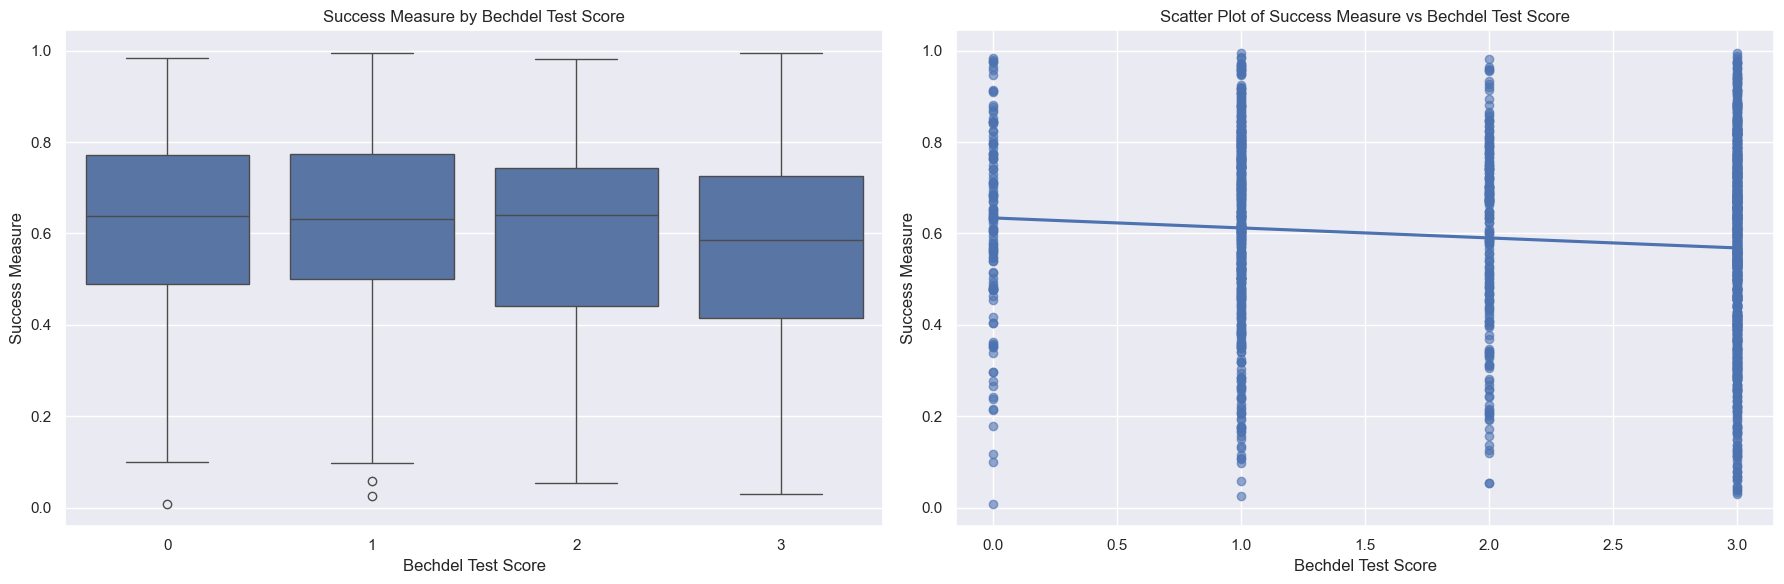

In [ ]:
valid_data = df_succes_bechdel[df_succes_bechdel['SuccessMetric'].notna()]

correlation, p_value = stats.pearsonr(valid_data['SuccessMetric'], valid_data['bechdel_score'])

corr_spear, p_spear = stats.spearmanr(valid_data['SuccessMetric'], valid_data['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")
print(f"Spearman correlation: {corr_spear}, p-value: {p_spear}")

# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Box Plot by Bechdel Score
sns.boxplot(data=df_succes_bechdel, x='bechdel_score', y='SuccessMetric', ax=axes[0])
axes[0].set_title('Success Measure by Bechdel Test Score')
axes[0].set_xlabel('Bechdel Test Score')
axes[0].set_ylabel('Success Measure')

# Subplot 2: Scatter Plot with Linear Regression
sns.regplot(data=df_succes_bechdel, x='bechdel_score', y='SuccessMetric', ax=axes[1], 
            ci=None, scatter_kws={'alpha':0.6})
axes[1].set_title('Scatter Plot of Success Measure vs Bechdel Test Score')
axes[1].set_xlabel('Bechdel Test Score')
axes[1].set_ylabel('Success Measure')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


From these results, we observe that it is statistically significant (given the small p-value) that there is a slight negative correlation between the Bechdel test score and the success measure of a film. In other words, as a film's success rating increases, its Bechdel test score appears to decrease slightly.

However, since the Pearson Correlation Coefficient is below 0.2, this correlation is quite weak and unlikely to be meaningful. This suggests that the Bechdel test result of a film is not strongly correlated with its success metrics.

Thus, based on this analysis, it can be inferred that a film's success is likely not dependent on the complexity of interactions between female characters, as measured by the Bechdel test. This indicates that other factors are more influential in driving a film's success, beyond just the representation of female interactions.

### Continuation:
Investigate how more nuanced interactions between female characters influence a film’s success, potentially using propensity score analysis to control for variables such as genre, number of female actresses, or release year. This would help isolate the specific impact of female representation on a film’s performance.

### Next step:
After the upcoming lectures on "Handling Text Data," we could explore methods to analyze which lexical fields in film summaries are more frequently associated with higher Bechdel test scores. This could help uncover particular themes or storylines that are linked to improved representation of women in films.






